# VITMAV45

```
http://bit.ly/VITMAV45-2023-GY

```
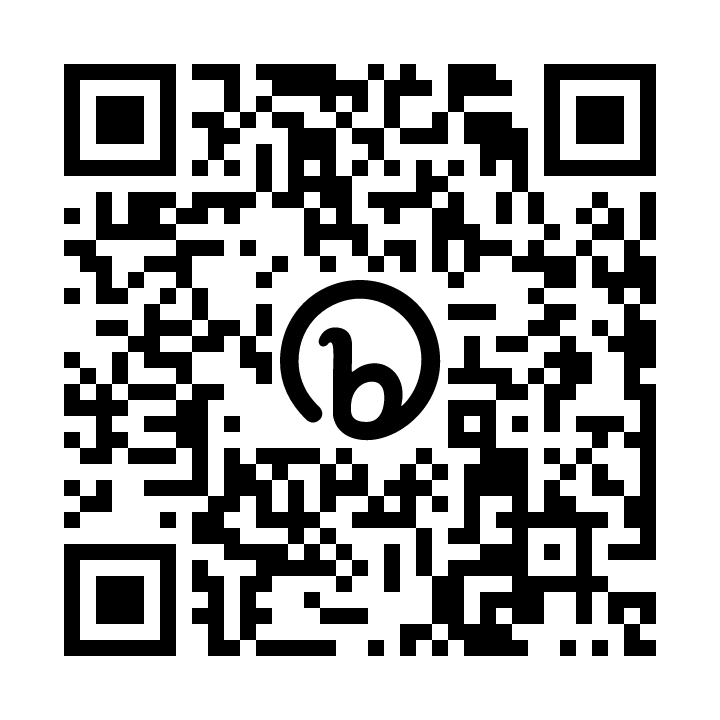


In [ ]:
!nvidia-smi

# 01 hét

In [ ]:
a=232



In [ ]:
import numpy as np

In [ ]:
a = np.array([1,2,3,4])

In [ ]:
a

In [ ]:
b= np.array([(1,2,3),(4,5,6)],dtype=float)

In [ ]:
b

In [ ]:
d= np.zeros((3,4))

In [ ]:
d

In [ ]:
e=np.ones((3,4,5),dtype=np.int16)

In [ ]:
e

In [ ]:
np.empty((2,4))

In [ ]:
np.linspace(0,2,9)

In [ ]:
np.linspace(-2*np.pi, 2*np.pi,15)

In [ ]:
np.arange(16)

In [ ]:
print(d)

In [ ]:
d[0]

In [ ]:
d[1,2]

In [ ]:
a=np.array([10,20,30,40])
b=np.arange(4)

In [ ]:
a-b

In [ ]:
a

In [ ]:
b

In [ ]:
b**2

In [ ]:
a<35

In [ ]:
A = np.array(([[1,1],[0,1]]))

In [ ]:
A

In [ ]:
B=np.array([[2,0],[3,4]])

In [ ]:
A*B

In [ ]:
np.dot(A,B)

In [ ]:
A.dot(B)

In [ ]:
np.random.random((2,3))

In [ ]:
np.random.seed(42)

In [ ]:
np.min(B,axis=0)

#02 hét


## XOR feladat neuron hálós megközelítése

Először a historikisan is nagy jelentőségű XOR problémát fogjuk megoldani "pure" Python-ban.

A XOR probléma a gépi tanulás szempontjából azért érdekes, mert míg az AND és az OR logikai függvények architektúrális szempontból megoldhatóak egyetlen neuron segítségével, addig a XOR-ra ez nem teljesül. Az AND és az OR esetében létezik a függvény által felveheto kimeneti értékek között egy olyan hipersík (szeparálósík), amely segítségével egyértelmű a szeparáció.

A XOR probléma további tárgyalásához tekintsük az alábbi igazságtáblát:


  A     | B   | A XOR B
  :----:| :----:|:--------:
  0     | 0   |    0
  1     | 0   |    1
  0     | 1   |    1
  1     | 1   |    0


In [ ]:
# A notebook alapú megjelenítés aktiválása
# (részletek: https://ipython.readthedocs.io/en/stable/interactive/plotting.html)
%matplotlib inline
import matplotlib.pyplot as plt # Pyplot grafikus megjelenítocsomag importálása
plt.rc('axes', axisbelow=True)  # Csinosítás: Rács, tengelyek, a grafikonok mögött

# A és B -> x és y bemeneti kombinációi és kimeneti értékek xor
xs   = [0, 1, 0, 1]
ys   = [0, 0, 1, 1]
xor  = [0, 1, 1, 0]
and_ = [0, 0, 0, 1]
or_  = [0, 1, 1, 1]

# Pontok ábrázolása. Piros -> 1 (Igaz), Kék-> 0(Hamis)
plt.scatter(xs, ys, c=xor, cmap='coolwarm')
# Megj.: megnézhetjünk 'c=and'_ és 'c=or_'-ral is a plottolást

# Csinosítás
# Színskála hozzáadása
plt.colorbar()

# A jobb ábrázálhatóság miatt, szélesebb tartományokat jelenítünk meg
plt.xlim(-0.5, 1.5)
plt.ylim(-0.5, 1.5)

# Négyzetrács megjelenítése
plt.grid(True)

# Az x és y tengely megjelenítése
plt.axhline(0, linestyle='dashed')
plt.axvline(0, linestyle='dashed');

Mint ahogy a fenti ábrán is látszódik, nem tudjuk egyetlen szeparáló síkkal (2 dimenzióban egyenessel) külön választani az igaz és a hamis értékeket.

Mivel egyetlen síkkal nem tudjuk szétválasztani a kimeneteket ezért a neurális hálózat be- és kimeneti rétege közé szükségszerű, hogy további, un. rejtett réteg(ek)et illesszünk be.

## Neuron háló felépítése
Mielőtt a konkrét programkóddal ismerkednénk meg, tekintsük át egy mesterséges neurális hálózat általános architektúráját, felépítését. Ahhoz, hogy neurális hálózatunk felügyelt tanítás során rendeltetésszerűen működjön, szükségünk van:

 - Tanító adatokra (bemenet és felügyelt esetben kimenet),
 - Magára a neurális hálózatra, amely magában foglal:
   - bemeneti réteget, egy kimeneti réteget, illetve köztük elhelyezkedo rejtett réteg(ek)et,
   - rétegenként tetszőleges számú neuronokat,
   - a rétegeket összekötő, különböző súlyokkal rendelkező éleket,
   - a neuronokon elvégzett lineáris (súlyozott összegzés), illetve nem lineáris függvényeket (pl. sigmoid, tanh, ReLU, stb.).
 - Tanítási fázist:
   - a bemenő adatokat "végigküldjük" a hálózaton (forward propagation),
   - a bemenő adatok alapján kiszámoljuk a hálózat által "jósolt" eredményt,
   - a jósolt eredmény és a tanító adatokban szereplő elvárt eredmény közötti kapcsolat kiszámítása (költségfüggvény),
   - a kapott hibaérték visszaterjesztése (backpropagation) a hálózaton, a láncszabály és a parciális deriválás módszerével (gradiensek kiszámítása)
   - a rétegek közötti súlyok frissítését a gradiensek segítségével.
   
Első lépésként importáljuk a már jól ismert Numpy csomagot, amire np-ként fogunk hivatkozni, illetve a további szükséges csomagokat:

In [ ]:
import numpy as np

In [ ]:
! pip install tensorboardX

In [ ]:
# tensorboard betöltése
%load_ext tensorboard

In [ ]:
from tensorboardX import SummaryWriter
from datetime import datetime # a pontos dátumot és időt is mentjük a logban
logdir = "logs"

### Aktivációs függvény
A "forward" lépésben a hálózatot alkotó neuronokkal két műveletet hajtunk végre: (1) Egy súlyozott lineáris összegzést, (2) illetve egy nemlineáris aktiválási függvényt. A lineáris függvény nem csinál mást, minthogy összegzi az adott neuronhoz beérkező értékeket a hozzá vezető súly értékével megszorozva. Ezután a kapott eredményen alkalmazzuk a nemlineáris aktivációs függvényt. Ez általában annyit csinál, hogy amennyiben az argumentuma (a korábbi szummázás)meghalad egy bizonyos küszöbértéket, akkor a neuron továbbítja a következő rétegre az adatokat. Itt a sigmoid-ot használjuk erre a célra, amit előbb definiálunk majd megnézzük, hogy hogyan néz ki:

$$
\mathrm{S}(x) = \frac{1}{1+e^{-x}}
$$

In [ ]:
def activation(x):
    return 1.0 / (1.0 + np.exp(-x))

In [ ]:
activation(0.01)

In [ ]:
segedX = np.linspace(-6,6,200)
y = activation(segedX)
plt.plot(segedX, y)

# A jobb ábrázálhatóság miatt, szélesebb tartományokat jelenítünk meg
plt.xlim(-6, 6)
plt.ylim(-0.5, 1.5)
# Az x és y tengely megjelenítése
plt.axhline(0, linestyle='dashed')
plt.axvline(0, linestyle='dashed');

Következőnek definiáljuk az aktivációs függvény deriváltját. A tanítási fázis során, a hiba végigterjesztésekor (backpropagation) az aktivációs függvényt, azaz annak a deriváltját használjuk. Definiáljuk majd nézzük meg ezt is, hogy hogyan néz ki sigmoid esetén:

$$
\frac{d\mathrm{S}(x)}{dx} = \frac{e^{-x}}{(1+e^{-x})^2}
$$

In [ ]:
def dactivation(x):
    return np.exp(-x) / (1 + np.exp(-x))**2

In [ ]:
plt.plot(segedX, dactivation(segedX))
plt.xlim(-6, 6)
plt.axhline(0, linestyle='dashed')
plt.axvline(0, linestyle='dashed');

### Neuronhálót megvalósító osztály
Most jön a java! Definiáljuk az MLP osztályt négy függvénnyel: inicializálás, súlyok resetelése, forward lépés, backward lépés.

In [ ]:
# MLP osztály létrehozása.
class MLP:

    def __init__(self, *args):
        """
        A hálózat inicializálása az argumentumként megadott méretek alapján.
        """
        # random seed megadása
        np.random.seed(123)
        # A hálózat formája (rétegek száma), amely megegyezik a paraméterek számával
        self.shape = args
        n = len(args)
        # Rétegek létrehozása
        self.layers = []
        # Bemeneti réteg létrehozása (+1 egység a BIAS-nak)
        self.layers.append(np.ones(self.shape[0]+1))
        # Rejtett réteg(ek) és a kimeneti réteg létrehozása
        for i in range(1,n):
            self.layers.append(np.ones(self.shape[i]))
        # Súlymátrix létrehozása
        self.weights = []
        for i in range(n-1):
            self.weights.append(np.zeros((self.layers[i].size,
                                         self.layers[i+1].size)))
        # dw fogja tartalmazni a súlyok utolsó módosításait (később pl. a momentum módszer számára)
        self.dw = [0,]*len(self.weights)
        # Súlyok újrainicializálása
        self.reset()

    def reset(self):
        """
        Súlyok újrainicializálása [-1, 1) intervallum fölött vett egyenletes eloszlás mintavételezésével
        """
        for i in range(len(self.weights)):
            # véletlen számok [0,1) tartományban
            Z = np.random.random((self.layers[i].size,self.layers[i+1].size))
            # átskálázzuk a súlyokat [-1,1) tartományba
            self.weights[i][...] = (2*Z-1)*1

    def propagate_forward(self, data):
        """
        A bemenő adatok végigküldése a hálózaton, kimeneti rétegig (forward propagation)
        """
        # Bemeneti réteg beállítása (tanító adatok)
        self.layers[0][0:-1] = data
        for i in range(1,len(self.shape)):
            s_i = np.dot(self.layers[i-1], self.weights[i-1])
            self.layers[i][...] = activation(s_i)
        # Visszatérés a hálózat által becsült eredménnyel
        return self.layers[-1]

    def propagate_backward(self, target, lrate=0.1):
        """
        Hibavisszaterjesztés (backpropagation) definiálása.
        Args:
            target: címkék, a kimenetek elvárt értékei
            lrate:
                A a learning rate (tanulási ráta) paraméter befolyásolja, hogy a hálózat súlyait milyen
                mértékben módosítsuk a gradiens függvényében. Ha ez az érték túl magas, akkor a háló
                "oszcillálhat" egy lokális vagy globális minimum körül. Ha túl kicsi értéket választunk,
                akkor pedig jelentősen több időbe telik mire elérjük a legjobb megoldást vagy leakad egy
                lokális minimumban és sose éri el azt. Defaults to 0.1.

        Returns: az aktuális kimenetek és elvárt értékek alapján számított (négyzetes) hiba
        """
        deltas = []
        # Hiba: 1/2 (y-y_kalap)**2
        # Hiba deriváltjának kiszámítása a kimeneti rétegen (dC/dy_kalap)
        derror = -(target-self.layers[-1]) # y-y_kalap
        # error*dactivation(s(3))
        s_last = np.dot(self.layers[-2],self.weights[-1])
        delta_last = derror * dactivation(s_last)
        deltas.append(delta_last)
        # Gradiens kiszámítása a rejtett réteg(ek)ben
        for i in range(len(self.shape)-2,0,-1):
            s_i = np.dot(self.layers[i-1],self.weights[i-1])
            # pl. utolsó rejtett réteg: delta(3)*(W(2).T)*dactivation(s(2)) (lásd előadás)
            delta_i = np.dot(deltas[0],self.weights[i].T)*dactivation(s_i)
            # a háló eleje felé "lépkedünk, mindig a deltas tömb elejére szúrjuk be az aktuálisan kiszámítottat"
            deltas.insert(0,delta_i)
        # Súlyok módosítása
        for i in range(len(self.weights)):
            layer = np.atleast_2d(self.layers[i])
            delta = np.atleast_2d(deltas[i])
            # pl. utolsó rétegben: delta(3)*a(2) (lásd előadás)
            dw = -lrate*np.dot(layer.T,delta)
            # súlyok módosítása
            self.weights[i] += dw

            # a súlymódosítás eltárolása
            self.dw[i] = dw

        # Visszatérés a hibával
        error = (target-self.layers[-1])**2
        return error.sum()

### Adatok előfeldolgozása és tanítás


In [ ]:
from sklearn import preprocessing
def learn(network, X, Y, valid_split, test_split, writer, epochs=20, lrate=0.1):

        # train-validation-test minták különválasztása
        nb_samples = len(Y)
        X_train = X[0:int(nb_samples*(1-valid_split-test_split))]
        Y_train = Y[0:int(nb_samples*(1-valid_split-test_split))]
        X_valid = X[int(nb_samples*(1-valid_split-test_split)):int(nb_samples*(1-test_split))]
        Y_valid = Y[int(nb_samples*(1-valid_split-test_split)):int(nb_samples*(1-test_split))]
        X_test  = X[int(nb_samples*(1-test_split)):]
        Y_test  = Y[int(nb_samples*(1-test_split)):]

        # standardizálás
        scaler = preprocessing.StandardScaler().fit(X_train)
        X_train = scaler.transform(X_train)
        X_valid = scaler.transform(X_valid)
        X_test  = scaler.transform(X_test)

        # ugyanolyan sorrendben keverjük be a bemeneteket és kimeneteket, a három külön adatbázisra
        randperm = np.random.permutation(len(X_train))
        X_train, Y_train = X_train[randperm], Y_train[randperm]


        # Tanítási fázis, epoch-szor megyünk át 1-1 véltelenszerűen kiválasztott mintán.
        for i in range(epochs):
            # Jelen megoldás azt a módszert használja, hogy a megadott
            # tanító adatokon végigmegyünk és minden elemet először végigküldünk
            # a hálózaton, majd terjeszti vissza a kapott eltérést az
            # elvárt eredménytől. Ezt hívjuk SGD-ek (stochastic gradient descent).
            train_err = 0
            for k in range(X_train.shape[0]):
                network.propagate_forward( X_train[k] )
                train_err += network.propagate_backward( Y_train[k], lrate )
            train_err /= X_train.shape[0]

            # validációs fázis
            valid_err = 0
            o_valid = np.zeros(X_valid.shape[0])
            for k in range(X_valid.shape[0]):
                o_valid[k] = network.propagate_forward(X_valid[k])
                valid_err += (o_valid[k]-Y_valid[k])**2
            valid_err /= X_valid.shape[0]


            writer.add_scalar('train', scalar_value=train_err, global_step=i)
            writer.add_scalar('validation', scalar_value=valid_err, global_step=i)
            print("%d epoch, train_err: %.4f, valid_err: %.4f" % (i, train_err, valid_err))

        # Tesztelési fázis
        print("\n--- TESZTELÉS ---\n")
        test_err = 0
        o_test = np.zeros(X_test.shape[0])
        for k in range(X_test.shape[0]):
            o_test[k] = network.propagate_forward(X_test[k])
            test_err += (o_test[k]-Y_test[k])**2
            print(k, X_test[k], '%.2f' % o_test[k], ' (elvart eredmeny: %.2f)' % Y_test[k])
        test_err /= X_test.shape[0]

        plt.scatter(X_test[:,0], X_test[:,1], c=np.round(o_test[:]), cmap=plt.cm.coolwarm)

In [ ]:
# Mesterséges neurális hálózat létrehozása, 2 bemenettel, 10 rejtett neuronnal és 1 kimenettel
network = MLP(2,10,1)

In [ ]:
# Tanító, validációs és teszt adatok megadása a rendszernek (zajjal terhelt XOR adatok)
nb_samples=1000
X = np.zeros((nb_samples,2))
Y = np.zeros(nb_samples)
for i in range(0,nb_samples,4):
    noise = np.random.normal(0,1,8)
    X[i], Y[i] = (-2+noise[0],-2+noise[1]), 0
    X[i+1], Y[i+1] = (2+noise[2],-2+noise[3]), 1
    X[i+2], Y[i+2] = (-2+noise[4],2+noise[5]), 1
    X[i+3], Y[i+3] = (2+noise[6],2+noise[7]), 0

# ...és az adatok kirajzolása
plt.scatter(X[:,0],X[:,1],c=Y[:], cmap=plt.cm.coolwarm.resampled(2), linewidth=1, edgecolors='w')
plt.colorbar(ticks=[0,1])
plt.show()

In [ ]:
# a pontos időt lekérdezzük majd string-re alakítjuk
now = datetime.now()
date_time = now.strftime("%Y%m%d_%H-%M-%S")
writer = SummaryWriter(logdir+"/"+date_time, flush_secs=1)


# Tanítás/Tesztelés indítása
network.reset()
valid_split = 0.2; test_split = 0.1
learn(network, X, Y, valid_split, test_split, writer)

In [ ]:
# Tensorboard futtatása
%tensorboard --logdir logs

In [ ]:
def decision_boundary_plot(network, X):
    """
    Háló kimenet illusztrálása a bemeneti sík "minden" (sok) pontjára
    Döntési határ közelítő megjelenítése
    Tesztontok megjelenítése és színezése a háló által becsült értékük szerint
    """
    # Generálunk a síkon egy sűrű rácsot, melynek minden pontjában kiértékeljük a háló kimenetét
    res = 250 # a egy-egy dimenzióban hány ponton értékeljük ki a kimenetet
    lims = 3  # A kirajzolás határának beállítása
    # lims = 10 értéket beállítva láthatjuk a háló általánosítóképességének korlátait
    x1 = x2 = np.linspace(-lims, lims, res)
    x1v, x2v = np.meshgrid(x1,x2)
    X_test2_grid = np.stack([x1v, x2v], axis=-1)
    X_test2 = np.reshape(X_test2_grid, (-1, 2))

    # Háló kimenet kiértékelése a rácspontokban
    Y_test2 = np.empty(X_test2.shape[0])
    for i in range(X_test2.shape[0]):
        Y_test2[i] = network.propagate_forward(X_test2[i,:])
    Y_test2_grid = np.reshape(Y_test2, (res,-1))
    # Ábrázolás
    plt.imshow(Y_test2_grid, cmap=plt.cm.coolwarm, origin='lower', extent=[-lims-0.5, lims+.5, -lims-0.5, lims+0.5], vmax=1 ,vmin=-0)
    plt.colorbar()
    plt.axhline(0, linestyle='dashed')
    plt.axvline(0, linestyle='dashed')
    plt.xlim(-lims, lims)
    plt.ylim(-lims, lims)

    # Közelítő döntési határ megkeresése.
    # Megkeressük a rácson azokat a pontokat melyek értéke kb 0.5 és ezeket ábrázoljuk
    # A kapott döntési határ nem egy "szép" görbe, de közelítőleg megmutatja a döntési határt
    is_decision_boundary = np.isclose(Y_test2_grid, 0.5, atol=1e-2)
    # print(np.sum(is_decision_boundary))
    decision_boundary_coords = X_test2_grid[is_decision_boundary]
    # print(decision_boundary_coords.shape)
    plt.scatter(decision_boundary_coords[:,0], decision_boundary_coords[:,1], marker='.')

    # A adatbázis tesztpontjain (ismét) kiértékeljük a háló kimenetét és ezeket is kirajzoljuk
    nb_samples = X.shape[0]
    X_test  = X[int(nb_samples*(1-test_split)):]
    # Y_test  = Y[int(nb_samples*(1-test_split)):]
    O_test = np.zeros(X_test.shape[0])
    for k in range(X_test.shape[0]):
        O_test[k] = network.propagate_forward(X_test[k])
    plt.scatter(X_test[:,0], X_test[:,1], c=np.round(O_test[:]), cmap=plt.cm.bwr, linewidth=1, edgecolors='w')

decision_boundary_plot(network, X)

# 03 hét
- Második hétről maradtak befejezése
- keras bevezetés

Az előzőleg bemutatott XOR problémát e notebookban egy Python alapokra építkező, gépi tanulást elősegítő keretrendszerrel, a Kerassal fogjuk megoldani. A Keras az egyik legelterjedtebb mély tanuló keretrendszer, köszönhetően magas szintű megvalósításának. Backend-nek TensorFlow-t és Thenao-t is tud használni.
A kódunk elején betöltjük a Keras csomagból a szükséges modulokat.

In [ ]:
# Először is, az egymáshoz képest szekvenciálisan elhelyezkedő neurális hálózat modelljét.
from tensorflow.keras.models import Sequential
# Szükségünk van továbbá az előrecsatolt rétegekre, illetve a rajtuk elvégzett aktivációs függvényre.
from tensorflow.keras.layers import Dense, Activation
# A Callback függvény rengeteg hasznos információt szolgáltat a tanítási folyamat során, amelyekre kíváncsiak
# szoktunk lenni.
from tensorflow.keras.callbacks import Callback, TensorBoard
# A tanulási folyamat során a széles körben alkalmazott Stochastic Gradient Descent metódust alkalmazzuk mini-batch-eken.
# Ennek segítségével tudjuk a tanulási paramétereket szabályozni.
from tensorflow.keras.optimizers import SGD
# A jól ismert Numpy betöltése.
import numpy as np
# Standardizáláshoz
from sklearn import preprocessing
# Matplotlib grafikus megjelenítőcsomag meghívása
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Random seed beállítása
np.random.seed(1)

Az előbb már említett Callback osztályra alapozva a TrainingHistory osztállyal tudunk kinyerni értékes metrikákat, amelyek a hálózat tanulási folyamatát jellemzik.

In [ ]:
class TrainingHistory(Callback):
    # Tanulási folyamat elején létrehozunk egy-egy üres listát a kinyerni kívánt metrikák tárolása céljából.
    def on_train_begin(self, logs={}):
        # Hiba mértéke a tanító adatokon.
        self.losses = []
        # Hiba mértéke a validációs adatokon.
        self.valid_losses = []
        # A modell jóságát, pontosságát mérő mutatószám a tanító adatokon.
        self.accs = []
        # A modell jóságát, pontosságát mérő mutatószám a validációs adatokon.
        self.valid_accs = []
        # A tanítási fázisok sorszámozása.
        self.epoch = 0

    # Minden egyes tanítási fázis végén mentsük el, hogy hogyan teljesít aktuálisan a háló.
    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        self.valid_losses.append(logs.get('val_loss'))
        self.accs.append(logs.get('acc'))
        self.valid_accs.append(logs.get('val_acc'))
        self.epoch += 1

history = TrainingHistory()

In [ ]:
# Modell felépítése
from keras import regularizers
# A modell struktúráját az egymásra linárisan épülő rétegek adják.
model = Sequential()
# Az első rejtett réteg definiálása, amely két bemenetről kapja az adatokat.
model.add(Dense(100, input_shape=(2,), activation="tanh"))

# A rétegen alkalmazott szigmoid (hiperbolikus tanges) aktivációs függvényt
# activation="tanh" megadása helyett külön "rétegként" is hozzáadhatjuk a hálóhoz".
# model.add(Activation("tanh"))
# Utolsó réteg definiálása, amelynek egy kimenete van.
model.add(Dense(1, activation="tanh"))

# A tanulás előtt be kell állítani, hogy a tanulási folyamat milyen paraméterek mentén történjen.
# Az első paraméter a hiba meghatározására az átlagos négyzetes hiba értéket fogjuk alkalmazni.
model.compile(loss='mean_squared_error',
              # A korábbiakban már említett SGD optimatizáló metódusban tudjuk meghatározni a tanulási rátát
              # a momemtum módszer értékét, illetve, hogy használjon a háló Nesterov-momemtum módszert.
              optimizer= SGD(learning_rate=0.1,
                             momentum=0.001,
                             nesterov=True),
              metrics=['accuracy'])

In [ ]:
# keras-vizualizer segítségével ábrázolhatjuk az háló struktúráját.
!pip3 install keras-visualizer

In [ ]:
from keras_visualizer import visualizer
visualizer(model, file_format='png', view=True)

In [ ]:
%matplotlib inline
img = mpimg.imread('graph.png')
fig = plt.figure(figsize=[20,9])
plt.imshow(img)
plt.show()

Tanító, validációs és tesztelő adatok
megadása, standardizálása és megjelenítése: zajjal terhelt XOR adatok

In [ ]:
nb_samples = 100
valid_split = 0.2
test_split = 0.1

samples = np.zeros(nb_samples, dtype=[('input', float, 2), ('output', float, 1)])
for i in range(0,nb_samples,4):
    noise = np.random.normal(0,1,8)
    samples[i] = (-2+noise[0],-2+noise[1]), 0
    samples[i+1] = (2+noise[2],-2+noise[3]), 1
    samples[i+2] = (-2+noise[4],2+noise[5]), 1
    samples[i+3] = (2+noise[6],2+noise[7]), 0

# ...és az adatok kirajzolása
plt.scatter(samples['input'][:,0],samples['input'][:,1],c=samples['output'][:], cmap=plt.cm.coolwarm.resampled(2), linewidth=1, edgecolors='w')
plt.colorbar(ticks=[0,1]);

samples_train = samples[0:int(nb_samples*(1-valid_split-test_split))]
samples_valid = samples[int(nb_samples*(1-valid_split-test_split)):int(nb_samples*(1-test_split))]
samples_test  = samples[int(nb_samples*(1-test_split)):]

# standardizálás
scaler = preprocessing.StandardScaler().fit(samples_train['input'])
samples_train['input'] = scaler.transform(samples_train['input'])
samples_valid['input'] = scaler.transform(samples_valid['input'])
samples_test['input'] = scaler.transform(samples_test['input'])

A továbbiakban un. callback függvényeket adunk meg, melyeket tanítás során hív meg a Keras deep learning keretrendszer:

In [ ]:
# Early stopping, amellyel figyeljük a validációs hibát (alap beállítás)
from keras.callbacks import EarlyStopping
patience=10
early_stopping=EarlyStopping(patience=patience, verbose=1)

# Szintén a validációs hibát figyeljük, és elmentjük a legjobb modellt
from keras.callbacks import ModelCheckpoint
checkpointer=ModelCheckpoint(filepath='weights.hdf5', save_best_only=True, verbose=1)

# a tanulálsi ráta (lr, learning rate) automatikus csökkentésére szolgáló függvény
from keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=20, min_lr=10e-5)

# a tanulási ráta kézzel írt szabályok alapján történő csökkentésére szolgáló függvény
# ezt most a tanítás során nem fogjuk használni, de érdemes kipróbálni a ReduceLROnPlateau
# függvény helyett
from keras.callbacks import LearningRateScheduler
def scheduler(epoch):
    result=0.1
    if (epoch>20):
        result=0.05
    if (epoch>40):
        result=10e-3
    if (epoch>60):
        result=0.1
    print("Learning rate: %f" % (result))
    return result

change_lr = LearningRateScheduler(scheduler)

In [ ]:
tensorboard_callback = TensorBoard(log_dir="./logs", write_graph=True, histogram_freq=1)


## A háló tanítása és tesztelése

Tanítási folyamat és annak a paraméterei. A paraméterek sorát a tanulási adatokkal kell kezdeni. Ez után számos paramétert definiálhatunk, melyek rövid magyarázatát kommentekben olvashatjátok:

In [ ]:
fit_history = model.fit(samples_train['input'], samples_train['output'],
          # A tanulási folyamat során beállíthatjuk, hogy a tanító adatsorból hány elem kerüljön bele egy-egy
          # batch-be.
          batch_size=50,
          # Tanulási fázisok száma.
          epochs=50,
          # Verbose paraméter a tanulás során közli azokat az információkat, amelyek mi szeretnénk kinyerni.
          # Értéke lehet 0, 1 és 2
          verbose=2,
          # A tanulással párhuzamosan a validáció is fut.
          validation_data=(samples_valid['input'],samples_valid['output']),
          # A korábbiakban már tárgyalt tanulást jellemző metrikákat a history nevű változóban szeretnénk tárolni.
          callbacks=[reduce_lr,
                     checkpointer,
                     #early_stopping,
                     #history,
                     tensorboard_callback],
          # A bemenő adatokat keverje meg a program (alapbeállítás: True).
          shuffle= True)

A hálózat hibájának megjelenítése mint a tanító, mind a validációs adathalmazon:

In [ ]:
fit_history.history.keys()

In [ ]:
plt.figure(figsize=(10, 5))
plt.title('Hiba mértéke')
plt.plot(fit_history.history['loss'], color ='g', label='Hiba mértéke a tanító adatokon')
plt.plot(fit_history.history['val_loss'], color ='b', label='Hiba mértéke a validációs adatokon')
plt.legend(loc='upper right')
plt.xlabel('Tanulási iterációk száma')
plt.ylabel('y')
plt.grid(True)
plt.show()

Tesztelés és megjelenítés fázisa:

In [ ]:
# a legjobb modell visszatöltése
from keras.models import load_model
model = load_model('weights.hdf5')
# teszt adatokkal prediktálás
preds=model.predict(samples_test['input'])
# hiba számítása a teszt adatokon
from sklearn.metrics import mean_squared_error
test_mse = mean_squared_error(samples_test['output'],preds)
print("Test MSE: %f" % (test_mse))
# predikció megjelenítése
fig1=plt.figure()
plt.scatter(samples_test['input'][:,0], \
            samples_test['input'][:,1], \
            c=np.round(preds[:,0]), cmap=plt.cm.coolwarm)

## A modell vizsgálata

In [ ]:
model.summary()

In [ ]:
print('Rétegek:\n')
for layer in model.layers:
    print("Réteg neve: ", layer.name, ', tanítható: ', layer.trainable)
    print(layer.get_config(),'\n')

In [ ]:
print("Súlyok:")
for i in range(len(model.layers)):
    print(model.get_layer(index=i).get_weights())

## TensorBoard-os logok vizsgálata

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir logs

## Feladat

Vizsgáljátok meg L1 és L2 regularizáció hatását a súly mátriuxra.

Segítség:

```
from keras import regularizers
model.add(Dense(10, input_shape=(2,), kernel_regularizer=regularizers.l2(0.1)))
...
model.add(Dense(1, kernel_regularizer=regularizers.l2(0.1)))
```

# 04 hét: Regresszió mély tanulással

Ebben a notebookban a gépi tanulás egyik "Hello world"-jét fogjuk megismeri. Ehhez a Californa Housing Prices adatbázist fogjuk felhasználni.

Az adatbázisról egy rövid leírást itt találunk:
https://scikit-learn.org/stable/datasets/real_world.html#california-housing-dataset

Részletesebb leírást, elemzést itt:
https://inria.github.io/scikit-learn-mooc/python_scripts/datasets_california_housing.html

Következő lépésként importáljuk a szükséges modulokat és állítsunk be egy random seed-et:

In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
import copy
import pandas as pd
from tensorflow.keras.optimizers import SGD
from sklearn.preprocessing import StandardScaler


np.random.seed(123)

Ezután töltsük le és töltsük be az adatokat, válasszuk szét a train-validation-test adathalmazokat és standardizáljuk a bemeneteket:

In [ ]:
from sklearn.datasets import fetch_california_housing

california_housing = fetch_california_housing(as_frame=True)

In [ ]:
california_housing.frame

In [ ]:
dataset = california_housing.frame.values
test_split = 0.1
valid_split = 0.1

X = dataset[:,0:-1]
Y = dataset[:,-1]

v_index = int(X.shape[0]*(1-valid_split-test_split))
t_index = int(X.shape[0]*(1-test_split))

X_test = X[t_index:]
Y_test = Y[t_index:]
X_valid = X[v_index:t_index]
Y_valid = Y[v_index:t_index]
X = X[:v_index]
Y = Y[:v_index]

scaler = StandardScaler().fit(X)
X = scaler.transform(X)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)


Ezt követően adjuk meg a callback függvényeket:

In [ ]:
patience=40
early_stopping=EarlyStopping(patience=patience, verbose=1)
checkpointer=ModelCheckpoint(filepath='weights.hdf5', save_best_only=True, verbose=1)

És hozzuk létre a hálót és tanítsuk be:

In [ ]:
model = Sequential()
model.add(Dense(units=200, input_dim=X.shape[1]))
model.add(Activation('sigmoid'))
model.add(Dropout(0.5))
model.add(Dense(units=1, activation='linear'))

sgd = SGD(learning_rate=1e-3, weight_decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='mse', optimizer=sgd)
history=model.fit(X,Y,epochs=10000,
                  batch_size=16,
                  verbose=2,
                  validation_data=(X_valid, Y_valid),
                  callbacks=[checkpointer, early_stopping])

A tanítás végeztével visszatöltjük a legjobb modellt, és kiértékeljük ennek teljesítményét a teszt adatokon. Mit jelenthet ez az érték?

In [ ]:
model = load_model('weights.hdf5')

from sklearn.metrics import mean_squared_error
import math

preds = model.predict(X_test)
test_err = mean_squared_error(Y_test,preds)
print("\nTeszt hiba: %f" % (test_err))
print(f"Ez az jelenti, hogy sqrt({test_err:0.3f}))={math.sqrt(test_err):0.3f}-at hibáz átlagosan a modell a teszt adatokon.")
print(f"Ez annyit jelent, hogy átlagosan {math.sqrt(test_err)*100000:0.0f}$-t téved a modellünk.")

Az eredményeket vizsgáljuk meg grafikusan is:

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
fig = sns.regplot(x=Y_test, y=preds.reshape(-1));
# fig.set(xlim=(10,30),ylim=(10,30))
plt.xlabel("Ground truth [$ 100 000]")
plt.ylabel("Predictions [$ 100 000]")
plt.show()

Mit jelent ez az ábra? Mit jelentene egy vízszintes egyenes? És egy függőleges egyenes?

# 05 hét:

## MNIST MLP

### MNIST adatbázis tanítása MLP-vel

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD

Ezt követően töltsük be az MNIST adatbázist:

In [ ]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [ ]:
# Explore shapes, values of the dataset
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_train[0])
print(X_train.min(), X_train.max())

In [ ]:
# Print and try to interpret X_train[0]
print(np.ceil(X_train[0]/255).astype(int))

In [ ]:
# plot using imshow
plt.imshow(X_train[0], cmap='gray')
plt.axis('off')
plt.show()

In [ ]:
# Reshape the data!
X_train = X_train.reshape(-1,28*28)
X_test = X_test.reshape(-1, 28*28)
X_train = X_train.astype("float32")
X_test = X_test.astype("float32")

# [0, 255] tartományba eső pixel értékek átskálázása [0, 1] intervallumba
X_train /= 255
X_test /= 255

nb_classes = 10

# a kimenetet onehot kódolásúvá alakítjuk
Y_train = to_categorical(y_train, nb_classes)
Y_test = to_categorical(y_test, nb_classes)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)
print(np.asarray(range(nb_classes)))
print(Y_train[0].astype(int))


Hozzuk létre a hálózatot:

In [ ]:
# Háló definiálása
model = Sequential()
model.add(Dense(units=256, input_shape=(784,), activation='relu'))
model.add(Dense(units=256, activation='relu'))
model.add(Dense(units=10, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=SGD(lr=0.001),
              metrics=['accuracy'])

Majd tanítsuk be a modellünket. Most nem határoztunk meg külön validációs adatbázist, hanem a model.fit függvény validation_split paramétereként adjuk meg, hogy hány százalékot használjon fel validációs célokra a tanítás:

In [ ]:
from tensorflow.keras.callbacks import TensorBoard
tb = TensorBoard(log_dir='logs', histogram_freq=1, write_graph=1)

In [ ]:
network_history = model.fit(X_train,
                            Y_train,
                            batch_size=128,
                            epochs=30,
                            verbose=1,
                            validation_split=0.2,
                            callbacks=[tb])

Ezután jelenítsük meg, a tanítás során a hibát és a pontosságot a tanító és validációs adatokon:

In [ ]:
def plot_history(network_history):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(network_history.history['loss'])
    plt.plot(network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])

    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(network_history.history['accuracy'])
    plt.plot(network_history.history['val_accuracy'])
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()

plot_history(network_history)

Vizsgáljuk meg a TensorBoard logokat is:

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir logs

### Hálózat vizsgálata

In [ ]:
model.summary()

In [ ]:
print('Bemenet: ', model.input)

In [ ]:
print('Rétegek:\n')
for layer in model.layers:
    print("Réteg neve: ", layer.name, ', tanítható: ', layer.trainable)
    print(layer.get_config(),'\n')

In [ ]:
print('Kimenet: ', model.output)

In [ ]:
# keras-vizualizer segítségével láthatjuk az hálót képformátumba
!pip3 install keras-visualizer
from keras_visualizer import visualizer
import matplotlib.image as mpimg
visualizer(model, file_format='png', view=True)
img = mpimg.imread('graph.png')
fig = plt.figure(figsize=[20,9])
plt.imshow(img)
plt.axis('off')

### Predikció és tévesztési mátrix

In [ ]:
preds=model.predict(X_test)

In [ ]:
print(preds.shape)

In [ ]:
from sklearn.metrics import confusion_matrix
conf=confusion_matrix(y_test,np.argmax(preds,axis=1))

#https://scikit-learn.org/stable/modules/model_evaluation.html#confusion-matrix

In [ ]:
import seaborn as sns; #sns.set()
ax = sns.heatmap(conf, annot=True, fmt='d', cmap=plt.cm.Blues)
ax.set(xlabel='Predicted Label',
       ylabel='True label');

### Képek feltöltése Tensorboardba

In [ ]:
import tensorflow as tf
logdir = "logs/images/"
file_writer = tf.summary.create_file_writer(logdir + "/mnist")
# Test névtérbe rakjuk a képeket
with tf.name_scope("Test") as scope:
  with file_writer.as_default():
    #Az első három tesztképet töltjük fel
    img = np.reshape(X_test[0:3], (-1, 28, 28, 1))
    tf.summary.image("MNIST Image 3", img, step=0,max_outputs=3,description="Info")

*Ajánlott forrás (inkább, de nem kizárólag haladóknak): Osztályozó hálók kimenetei valószínűségek? https://jtuckerk.github.io/prediction_probabilities.html*
![](https://jtuckerk.github.io/prediction_probabilities/images/correct_ratio.png)



## MNIST CNN feladat
Ajánlott forrás CNN témakörben: https://cs231n.github.io/convolutional-networks/

Egyszerű (nem szükségszerűen neurális hálóban található) konvolúció demó: https://deeplizard.com/resource/pavq7noze2


[`http://bit.ly/VITMAV45-task2`](http://bit.ly/VITMAV45-task2)

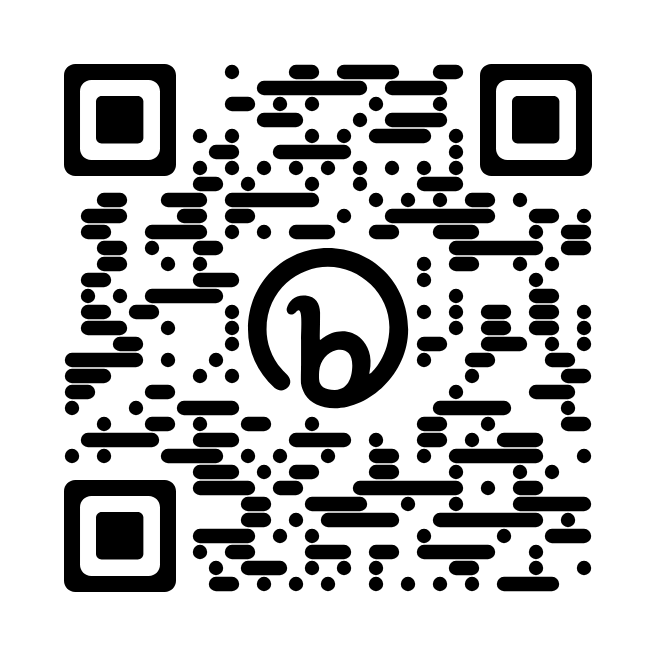

## MNIST CNN megoldás

### Konvolúciós neurális hálózatok - alapok
Jelen notebookban a konvolúciós hálók használatának alapjaival ismerkedünk meg. Az itteni példa publikusan elérhető kép adatbázisok két dimenziós konvolúciós hálózattal történő feldolgozásáról fog szólni. Fontos megjegyezni, hogy ahogy a konvolúciós hálók felhasználása ma már sokkal bővebb, mint pusztán képfelismerés, szinte bármilyen tématerületen sikeresen alkalmazzák (pl. beszéd, hang, idősorok, játék botok, stb.).

Az első példánkban Yann LeCunn professzor MNIST kézzel írott szám adatbázisát fogjuk betanítani a hálóval. Az adatbázis elérhető publikusan: http://yann.lecun.com/exdb/mnist/
Illetve szinte mindegyik nagyobb deep learning frameworkben be lehet tölteni parancssorból. A mostani példában előbb a Keras-t fogjuk használni, majd a Tensorflow 2.0 Keras interfészét. Az adatokat is a Keras-on keresztül töltjük be:

In [ ]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [ ]:
x_train.dtype

In [ ]:
x_train = x_train / 255
x_test = x_test / 255

x_train = x_train.reshape(-1,28,28,1)
x_test = x_test.reshape(-1,28,28,1)
x_train = x_train.astype("float32")
x_test = x_test.astype("float32")

y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

batch_size=128

A tanítás előtt kapcsoljuk be a GPU-t Colab alatt (Runtime/Change runtime type). Ezután létrehozunk egy egyszerű modellt softmax aktivációs függvénnyel és betanítjuk batch_size batch mérettel:

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, Embedding
from tensorflow.keras.optimizers import SGD

model = Sequential()
model.add(Conv2D(32, kernel_size=(5, 5), activation='relu', input_shape=(28,28,1,)))
model.add(Conv2D(64, (5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

print(model.summary())


In [ ]:
# Early stopping, amellyel figyeljük a validációs hibát (alap beállítás)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
patience=10
early_stopping=EarlyStopping(patience=patience, verbose=1)
# Szintén a validációs hibát figyeljük, és elmentjük a legjobb modellt
checkpointer=ModelCheckpoint(filepath='model.hdf5', save_best_only=True, verbose=1)
tb = TensorBoard(log_dir='logs', histogram_freq=1, write_graph=1)

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

network_history = model.fit(x_train, y_train, batch_size=128, epochs=30, verbose=1, validation_split=0.2, callbacks=[early_stopping, checkpointer, tb])

Ezután visszatöltjük a legjobb modellt és teszteljük:

In [ ]:
from keras.models import load_model
model = load_model("model.hdf5")
test_err = model.evaluate(x_test,y_test)
print("Teszt hiba:", test_err[0], "Teszt pontosság:", test_err[1])

### Metrikák, tévesztési mátrix
Nézzük először, hogy hogyan tudjuk kiszámolni az osztályozáshoz tartozó legfontosabb metrikákat és hogyan tudjuk megjeleníteni a konfúziós mátrixot:

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, confusion_matrix,classification_report
# először is nyerjük ki a predikciókat (valószínüség és hozzá tartozó pontosságot)
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred,1)
y_true = np.argmax(y_test,1)

print("test accuracy: %g" %(accuracy_score(y_true, y_pred)))
print("Precision", precision_score(y_true, y_pred, average="macro"))
print("Recall", recall_score(y_true, y_pred, average="macro"))
print("f1_score", f1_score(y_true, y_pred, average="macro"))
print("\nKonfúziós mátrix: ")
conf=confusion_matrix(y_true, y_pred)
print(conf)

A tévesztési mátrixot vizuálisan is érdemes vizsgálni:

In [ ]:
import seaborn as sns
ax = sns.heatmap(conf, annot=True, fmt='d', vmax=20, cmap='Blues') # a vmax paraméterrel állítjuk be, hogy milyen értéktartományban jelenítse meg az adatokat
ax.set(xlabel='Predicted Label',
       ylabel='True label');

Fontos felhívni a figyelmet a precision, recall és f1 esetén az "avarage" paraméterre. Mivel ezek a metrikák alapvetően két osztályt vesznek figyelembe, ezért több lehetőségünk van több osztálynál az értékek figyelembe vételére. Ennek talán legegyszerűbb módja a "macro", amikor minden osztálynál kiszámolt érték átlagát veszi. Ha "micro"-ra állítjuk, akkor összegzi az összes osztály esetén a TP, TN, FN, FP értékeket és ezekkel számol. "weighted" esetben pedig azt is figyelembe veszi, hogy melyik osztályban mennyi minta van, és amelyikbe sok, azt nagyobb súllyal veszi figyelembe.

Vizsgáljuk meg a TensorBoard-ban a logokat:

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir logs

### Aktíváció vizsgálata a convoluciós rétegekben
https://towardsdatascience.com/visualizing-intermediate-activations-of-a-cnn-trained-on-the-mnist-dataset-2c34426416c8 alapján

In [ ]:
#új modell készítése az aktivációs elemzéshez
from keras.models import Model
# Az első két réteger nézzük csak
layer_outputs = [layer.output for layer in model.layers[0:2]]
activation_model = Model(inputs=model.input,outputs=layer_outputs)

In [ ]:
#Kiválasztjuk a teszthalmaz első 4 képét
img = x_test[0:4].reshape(-1,28,28,1)
#Ezek a cimkék: 7,2,1,0
np.argmax(y_test[0:4],axis=1)

In [ ]:
#A 4 db képet ráadjuk a hálózatra:
activations = activation_model.predict(img)

In [ ]:
#Kigyűjtjük a rétegek neveit
layer_names = []
for layer in model.layers[0:2]:
    layer_names.append(layer.name)


In [ ]:
import matplotlib.pyplot as plt
images_per_row = 32
for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
    n_features = layer_activation.shape[-1] # Number of features in the feature map
    size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
    n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
    ns= layer_activation.shape[0]
    display_grid = np.zeros((size * n_cols*ns, images_per_row * size))
    for s in range(ns):
      for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            channel_image = layer_activation[s,
                                             :, :,
                                             col * images_per_row + row]
            #Az aktivációt normalizálhatjuk is, ekkor kicsi más jellegű képeket kapuk. Érdemes kipróbálni True és False-al is
            #Új kép generálása előtt az aktivációt is generáljuk újra!
            if False:
              channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
              channel_image /= channel_image.std()
              channel_image *= 64
              channel_image += 128
              channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[(col) * size+ size * n_cols*s: (col + 1) * size+ size * n_cols*s, # Displays the grid
                         row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    xticks = np.arange(0, size * images_per_row, size)
    plt.xticks(xticks - 0.5, xticks) # -0.5, because imshow places pixel centers on integer ticks so a pixel' left corner is at -0.5
    yticks = np.arange(0, size * n_cols*ns, size)
    plt.yticks(yticks - 0.5, yticks)
    plt.grid(True)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

#06. hét

In [ ]:
import os
from urllib.request import urlretrieve
from tensorflow.keras.applications.inception_v3 import InceptionV3,preprocess_input,decode_predictions
#from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
import numpy as np

In [ ]:
url_dog="https://s3.amazonaws.com/cdn-origin-etr.akc.org/wp-content/uploads/2017/11/12234558/Chinook-On-White-03.jpg"
urlretrieve(url_dog, "dog.jpg")

In [ ]:
model = InceptionV3(weights='imagenet', include_top=True)
#model = ResNet50(weights='imagenet', include_top=True)

In [ ]:
model.summary()

In [ ]:
img_path = 'dog.jpg'

img = image.load_img(img_path, target_size=(299, 299)) # Inception V3 esetén 299x299 a bemeneti kép mérete
#img = image.load_img(img_path, target_size=(224, 224)) # ResNet50 esetén 224x224 a bemeneti kép mérete
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(img)

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(x[0])

In [ ]:
preds = model.predict(x)
print('Jósolt osztály:')
print(decode_predictions(preds))

In [ ]:
import os
import zipfile

!wget --no-check-certificate https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip -O /tmp/cats_and_dogs_filtered.zip

In [ ]:
local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [ ]:
base_dir = '/tmp/cats_and_dogs_filtered' # Linux esetén
#base_dir = 'cats_and_dogs_filtered' # Windows esetén erre módosítsuk, ha a script mellé tömörítettük ki a ZIP fájlt
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

In [ ]:
train_cat_fnames = os.listdir(train_cats_dir)
print(train_cat_fnames[:10])
train_dog_fnames = os.listdir(train_dogs_dir)
train_dog_fnames.sort()
print(train_dog_fnames[:10])

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# megadjuk, hogy hány sor és oszlop jelenjen meg
nrows = 4
ncols = 4

fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

next_cat_pix = [os.path.join(train_cats_dir, fname) for fname in train_cat_fnames[:int(ncols*nrows/2)]]
next_dog_pix = [os.path.join(train_dogs_dir, fname) for fname in train_dog_fnames[:int(ncols*nrows/2)]]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
    sp = plt.subplot(nrows, ncols, i + 1)
    img = mpimg.imread(img_path)
    plt.imshow(img)

plt.show()

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3,preprocess_input,decode_predictions
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras import backend as K
import numpy as np

In [ ]:
img_height=299
img_width=299

In [ ]:
# előtanított modell betöltése, a fully-connected rétegek nélkül
base_model = InceptionV3(weights='imagenet', include_top=False)
# az utolsó konvolúciós réteg utána egy global average pooling réteget teszünk, ez rögtön "lapítja" (flatten) a 2D konvolúciót
x = base_model.output
x = GlobalAveragePooling2D()(x)
# ezután hozzáadunk egy előrecsatolt réteget ReLU aktivációs függvénnyel
x = Dense(1024, activation='relu')(x)
# és végül egy kimenete lesz a hálónak - a "binary_crossentropy" költségfüggvénynek erre van szüksége
predictions = Dense(1, activation='sigmoid')(x)
# a model létrehozása
model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
model.summary()

In [ ]:
for layer in base_model.layers:
    layer.trainable = False

# lefordítjuk a modelt (fontos, hogy ezt a rétegek befagyasztása után csináljuk"
# mivel két osztályunk van, ezért bináris keresztentrópia költségfüggvényt használunk
model.compile(optimizer='adam', metrics=['accuracy'],loss='binary_crossentropy')

In [ ]:
# kép felkészítése a betöltésre és adatdúsításra
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(train_dir, target_size=(img_height, img_width), batch_size=20, class_mode='binary')
validation_generator = test_datagen.flow_from_directory(validation_dir, target_size=(img_height, img_width), batch_size=20, class_mode='binary')


In [ ]:
# ez a függvény egyszerre végzi az adatdúsítást és a háló tanítását
model.fit_generator(train_generator,steps_per_epoch=200,validation_data=validation_generator,validation_steps=10,epochs=3)

In [ ]:
# ehhez először nézzük meg a háló felépítését
print("Az Inception V3 konvolúciós rétegei:")
for i, layer in enumerate(base_model.layers):
    print(i, layer.name)

In [ ]:
for layer in model.layers[:172]:
       layer.trainable = False
for layer in model.layers[172:]:
       layer.trainable = True

In [ ]:
# ez után újra le kell fordítanunk a hálót, hogy most már az Inception V3 felsőbb rétegei tanuljanak
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), metrics=['accuracy'], loss='binary_crossentropy')

In [ ]:
model.fit_generator(train_generator,steps_per_epoch=200,validation_data=validation_generator,validation_steps=10,epochs=3)
print("Tanítás vége.")

In [ ]:
!wget https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-160.tgz -O imagenette2-160.tgz
!tar -xf imagenette2-160.tgz

In [ ]:
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt

%matplotlib inline

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical, image_dataset_from_directory
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
!ls /content/imagenette2-160/
!ls /content/imagenette2-160/train

In [ ]:
run_id = 0

In [ ]:
image_size = 160
num_classes = 10
batch_size = 256

train_ds = image_dataset_from_directory("/content/imagenette2-160/train",
                                        label_mode='categorical',
                                        image_size=(image_size, image_size),
                                        batch_size=batch_size)
val_ds = image_dataset_from_directory("/content/imagenette2-160/val",
                                      label_mode='categorical',
                                      image_size=(image_size, image_size),
                                      batch_size=batch_size)

In [ ]:
# előtanított modell betöltése, a fully-connected rétegek nélkül
base_model = ResNet50(weights='imagenet', include_top=False) # Érdemes kipróbálni előtanított súlyok betöltése nélkül(weights=None)!

# az utolsó konvolúciós réteg utána egy global average pooling réteget teszünk, ez rögtön "lapítja" (flatten) a 2D konvolúciót
x = base_model.output
x = GlobalAveragePooling2D()(x)
# ezután hozzáadunk egy előrecsatolt réteget ReLU aktivációs függvénnyel
x = Dense(128, activation='relu', kernel_initializer='he_normal')(x)
# és végül egy kimenete lesz a hálónak - a "binary_crossentropy" költségfüggvénynek erre van szüksége
predictions = Dense(num_classes, activation='softmax')(x)

for layer in base_model.layers[:171]:
    layer.trainable = False

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(loss='categorical_crossentropy', optimizer=SGD(lr=0.001), metrics=['accuracy'])

In [ ]:
run_id += 1

network_history = model.fit(train_ds,
                            epochs=5,
                            verbose=1,
                            validation_data=val_ds,
                            callbacks=[])

In [ ]:
model.save("model.hdf5")

In [ ]:

from keras.models import load_model
model = load_model("model.hdf5")
test_err = model.evaluate(val_ds)
print("Teszt hiba:", test_err[0], "Teszt pontosság:", test_err[1])

In [ ]:
from tqdm.notebook import tqdm
preds = []
targets = []
for x, y in tqdm(val_ds):
    preds.extend(model.predict(x))
    targets.extend(y)

In [ ]:
preds = np.array(preds).squeeze()
targets = np.array(targets)
print(preds.shape)
print(targets.shape)

preds = np.argmax(preds, axis=1)
targets = np.argmax(targets, axis=1)
print(preds.shape)
print(targets.shape)

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
conf=confusion_matrix(targets, preds)

# print("test accuracy: %g" %(100* accuracy_score(targets, preds)))
#https://scikit-learn.org/stable/modules/model_evaluation.html#confusion-matrix

In [ ]:
import seaborn as sns; #sns.set()
plt.figure(figsize=(10,10))
ax = sns.heatmap(conf, annot=False, fmt='d', cmap=plt.cm.Blues)
ax.set(xlabel='Predicted Label',
       ylabel='True label');

In [ ]:
model.summary()

#10. hét

**Konvolúciós autoenkóder**

In [ ]:
from tensorflow import keras

In [ ]:
# MNIST mérete: 28x28

# encoder rész
encoder = keras.models.Sequential([
    keras.layers.Reshape([28, 28, 1], input_shape=[28, 28]),
    keras.layers.Conv2D(16, kernel_size=(3, 3), padding="same", activation="relu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(32, kernel_size=(3, 3), padding="same", activation="relu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(64, kernel_size=(3, 3), padding="same", activation="relu"),
    keras.layers.MaxPool2D(pool_size=2)
])

# itt (3 x 3 x 64) azaz 576-dimenziós reprezentáció

# szóban:
# adat tömörítésre nem túl jó...
# de felügyelet nélküli előtanítás pl. osztályozóhoz, ha kevés a címkézett adat
# mert az encoder hálózat első konvolúciós rétegei jellemzőkinyerést csinálnak

encoder.summary()


In [ ]:
# dekóder: ugyanaz, csak Conv2DTranspose rétegekkel
decoder = keras.models.Sequential([
    keras.layers.Conv2DTranspose(32, kernel_size=(3, 3), strides=2, padding="valid", activation="relu",
                                 input_shape=[3, 3, 64]),
    keras.layers.Conv2DTranspose(16, kernel_size=(3, 3), strides=2, padding="same", activation="relu"),
    keras.layers.Conv2DTranspose(1, kernel_size=(3, 3), strides=2, padding="same"),
    keras.layers.Reshape([28, 28])
])

decoder.summary()

In [ ]:
# modell a teljes AE-re
autoencoder = keras.models.Sequential([encoder, decoder])

autoencoder.summary()

autoencoder.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [ ]:
# tanítóadatok
from keras.datasets import mnist

(x_train, _) ,(x_test, _) = mnist.load_data()

print(x_train.shape, x_test.shape)

# teszt részt kettéválasztjuk még, hogy legyen külön validációs halmaz
from sklearn.model_selection import train_test_split
[x_test, x_valid] = train_test_split(x_test, test_size=0.5)

x_train = x_train / 255
x_valid = x_valid / 255
x_test = x_test / 255

print(x_train.shape, x_valid.shape, x_test.shape)

In [ ]:
# tanítás
autoencoder.fit(x_train, x_train,
                epochs = 10,
                batch_size = 128,
                shuffle = True,
                validation_data = (x_valid, x_valid))

In [ ]:
# néhány digiten encode és decode
encoded_imgs = encoder.predict(x_test)
decoded_imgs = autoencoder.predict(x_test)

In [ ]:
# milyen méretű a háló közepe, a 'bottleneck'?
print(encoded_imgs.shape)

In [ ]:
import matplotlib.pyplot as plt

# eredeti és visszaállított képek kirajzolása
n = 8
plt.figure(figsize=(16, 4))
for i in range(n):
  # eredeti
  ax = plt.subplot(2, n, i + 1)
  ax.set_title('eredeti')
  plt.imshow(x_test[i].reshape(28,28))
  plt.gray()

  # visszaállított
  ax = plt.subplot(2, n, i + 1 + n)
  ax.set_title('visszaállított')
  plt.imshow(decoded_imgs[i].reshape(28,28))
  plt.gray()

In [ ]:
print(encoded_imgs[i].shape)

In [ ]:
# encoder utáni eredmény, bottleneck reprezentáció
n = 8
plt.figure(figsize=(16, 4))
for i in range(n):
  # eredeti
  ax = plt.subplot(1, n, i + 1)
  plt.imshow(encoded_imgs[i].reshape(3*3, 64).T)
  plt.gray()

**Adat tisztítás**

In [ ]:
from tensorflow import keras

In [ ]:
# ugyanaz az autoenkóder, mint az előző példában  (átmásolni ide, encoder+decoder)

autoencoder.summary()

autoencoder.compile(optimizer = 'adam', loss = 'mean_squared_error')


In [ ]:
# tanítóadatok, mint az előző példában
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

(x_train, _) ,(x_test, _) = mnist.load_data()

print(x_train.shape, x_test.shape)

# teszt részt kettéválasztjuk még, hogy legyen külön validációs halmaz
from sklearn.model_selection import train_test_split
[x_test, x_valid] = train_test_split(x_test, test_size=0.5)

x_train = x_train / 255
x_valid = x_valid / 255
x_test = x_test / 255

print(x_train.shape, x_valid.shape, x_test.shape)

In [ ]:
# fehérzaj hozzákeverése az adatokhoz
noise_factor = 0.3
x_train_noisy = x_train + noise_factor * np.random.normal(size=x_train.shape)
x_valid_noisy = x_valid + noise_factor * np.random.normal(size=x_valid.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(size=x_test.shape)

In [ ]:
# 0-1 közé
x_train_noisy = np.clip(x_train_noisy, 0, 1)
x_valid_noisy = np.clip(x_valid_noisy, 0, 1)
x_test_noisy = np.clip(x_test_noisy, 0, 1)

In [ ]:
# zajos képek kirajzolása
n = 8
plt.figure(figsize=(16, 4))
for i in range(n):
  # eredeti
  ax = plt.subplot(1, n, i + 1)
  ax.set_title('zajos')
  plt.imshow(x_test_noisy[i].reshape(28,28))
  plt.gray()

In [ ]:
# tanítás
# bemenet: zajos képek
# kimenet: eredeti (zajmentes) képek
autoencoder.fit(x_train_noisy, x_train,
               epochs = 10,
               batch_size = 128,
               shuffle = True,
               validation_data = (x_valid_noisy, x_valid))

In [ ]:
decoded_imgs = autoencoder.predict(x_test_noisy)

In [ ]:
# eredeti, zajos és visszaállított képek kirajzolása
n = 8
plt.figure(figsize=(16, 4))
for i in range(n):
  # eredeti
  ax = plt.subplot(3, n, i + 1)
  ax.set_title('eredeti')
  plt.imshow(x_test[i].reshape(28,28))
  plt.gray()

  # zajos
  ax = plt.subplot(3, n, i + 1 + n)
  ax.set_title('eredeti')
  plt.imshow(x_test_noisy[i].reshape(28,28))
  plt.gray()

  # visszaállított
  ax = plt.subplot(3, n, i + 1 + 2 * n)
  ax.set_title('visszaállított')
  plt.imshow(decoded_imgs[i].reshape(28,28))
  plt.gray()
plt.show()

In [ ]:
# konklúzió: zajmentesítésre használható az AE
# de: ez csak az adott zaj típusra működik jól...

In [ ]:
# más típusú zaj hozzáadása a képekhez
# szemre kb hasonlóan zajos; de mi lesz a denoising AE eredménye?
noise_factor = 0.4
x_test_noisy = x_test + noise_factor * np.random.lognormal(0, 1, size=x_test.shape)
x_test_noisy = np.clip(x_test_noisy, 0, 1)

# ez a rész ugyanaz, mint fent

decoded_imgs = autoencoder.predict(x_test_noisy)

# eredeti, zajos és visszaállított képek kirajzolása
n = 8
plt.figure(figsize=(16, 4))
for i in range(n):
  # eredeti
  ax = plt.subplot(3, n, i + 1)
  ax.set_title('eredeti')
  plt.imshow(x_test[i].reshape(28,28))
  plt.gray()

  # zajos
  ax = plt.subplot(3, n, i + 1 + n)
  ax.set_title('eredeti')
  plt.imshow(x_test_noisy[i].reshape(28,28))
  plt.gray()

  # visszaállított
  ax = plt.subplot(3, n, i + 1 + 2 * n)
  ax.set_title('visszaállított')
  plt.imshow(decoded_imgs[i].reshape(28,28))
  plt.gray()
plt.show()

**Anomália detekció**

In [ ]:
# creditcard.csv: hitelkártya fizetési adatok kaggle versenyről

# időnként lassú a letöltés, akár 10p is lehet - időben elkezdeni!
# !wget smartlab.tmit.bme.hu/csapo/dl/creditcard.csv
!wget https://raw.githubusercontent.com/nsethi31/Kaggle-Data-Credit-Card-Fraud-Detection/master/creditcard.csv

In [ ]:
import tensorflow as tf
from tensorflow import keras

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# adatok beolvasása pandas dataframe-be
df = pd.read_csv('creditcard.csv')

In [ ]:
# először nézzük át, mi van az adatokban!

In [ ]:
df.shape

In [ ]:
# V1...V28: tömörített, anonimizált adat
# Time: időbélyeg
# Amount: összeg
# Class: osztály (0: normál, 1: csalás)
df

In [ ]:
# van-e benne hiányzó érték
df.isnull().values.any()

In [ ]:
# normál / csalás tranzakciók aránya
frauds = df[df.Class == 1]
normal = df[df.Class == 0]
print('normál:', normal.shape, 'csalás:', frauds.shape)

In [ ]:
# mennyire különböző a normál / csalás tranzakciók összege?
frauds.Amount.describe()

In [ ]:
normal.Amount.describe()

In [ ]:
# mennyire különböző a normál / csalás tranzakciók összege?  - hisztogramon ábrázolva
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(15,5))

ax1.hist(frauds.Amount, bins = 20)
ax1.set_title('Csalás')

ax2.hist(normal.Amount, bins = 50)
ax2.set_title('Normál')
plt.xlabel('Összeg ($)')
plt.ylabel('Tranzakciók száma')
plt.xlim((0, 20000))
plt.yscale('log')

In [ ]:
# csalás tranzakciók: látszik valamilyen mintázat időben?
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(15,5))

ax1.scatter(frauds.Time, frauds.Amount)
ax1.set_title('Csalás')

ax2.scatter(normal.Time, normal.Amount)
ax2.set_title('Normál')

plt.xlabel('Idő (s)')
plt.ylabel('Összeg')


In [ ]:
# adatok átrendezése: időtől nem függ, ezért azt az oszlopot töröljük
df = df.drop('Time',axis=1)

frauds = df[df.Class == 1]
normal = df[df.Class == 0]

In [ ]:
# csak a normál adatokat vesszük ki, és erre tanítunk majd AE-t
X_normal = normal.drop('Class',axis=1).values

In [ ]:
# train-valid-test split
X_normal_train, X_normal_test = train_test_split(X_normal,test_size=0.1)
X_normal_valid, X_normal_test = train_test_split(X_normal_test,test_size=0.5)

X_frauds_test = frauds.drop('Class',axis=1).values

In [ ]:
# adatok normalizálása
data_scaler = MinMaxScaler()
X_normal_train = data_scaler.fit_transform(X_normal_train)

X_normal_valid = data_scaler.transform(X_normal_train)
X_normal_test = data_scaler.transform(X_normal_test)
X_frauds_test = data_scaler.transform(X_frauds_test)

In [ ]:
X_normal_train.shape, X_normal_valid.shape, X_normal_test.shape, X_frauds_test.shape

In [ ]:
# AE, bottleneck=2 ---> 2D-re tömörítjük az adatokat
data_in = keras.layers.Input(shape=(29,))
encoded = keras.layers.Dense(2,activation='tanh')(data_in)
decoded = keras.layers.Dense(29,activation='sigmoid')(encoded)
autoencoder = keras.models.Model(data_in,decoded)

In [ ]:
autoencoder.compile(optimizer='adam',loss='mean_squared_error')

In [ ]:
autoencoder.fit(X_normal_train, X_normal_train, epochs = 5, batch_size=128, validation_data=(X_normal_valid,X_normal_valid))

In [ ]:
# nézzük meg, mit tanul meg az AE a normál tranzakciókról
reconstructions_normal = autoencoder.predict(X_normal_test)

In [ ]:
# kirajzolunk egy eredeti és visszaállított adatpontot
plt.plot(X_normal_test[10], 'r')
plt.plot(reconstructions_normal[10], 'b')
plt.legend(['normál / eredeti', 'normál / visszaállított'])

In [ ]:
# nézzük meg, mit tanul meg az AE a csalás tranzakciókról
reconstructions_frauds = autoencoder.predict(X_frauds_test)

In [ ]:
# kirajzolunk egy eredeti és visszaállított adatpontot
plt.plot(X_frauds_test[10], 'r')
plt.plot(reconstructions_frauds[10], 'b')
plt.legend(['csalás / eredeti', 'csalás / visszaállított'])

In [ ]:
# megfigyelés: a 'csalás' tranzakciókat csak nagyobb hibával tudja visszaállítani az AE, mint a normál tranzakcióknál

In [ ]:
# nézzük meg a visszaállítás hibájának eloszlását a 'normál' tranzakciókon!

reconstructions_normal = autoencoder.predict(X_normal_test)
test_loss = tf.keras.losses.mae(reconstructions_normal, X_normal_test)

plt.hist(test_loss[None,:], bins=50)
plt.xlabel("Teszt hiba (normál)")
plt.ylabel("Tranzakciók száma")

In [ ]:
# a fenti ábra alapján úgy tűnik, hogy ha a 'teszt hiba' > 0.05, akkor gyanús az adat
# azaz ezt érdemes a normál / csalás közti küszöb-nek beállítani!

In [ ]:
# nézzük meg a visszaállítás hibájának eloszlását a 'csalás' tranzakciókon!

reconstructions_frauds = autoencoder.predict(X_frauds_test)
test_loss = tf.keras.losses.mae(reconstructions_frauds, X_frauds_test)

plt.hist(test_loss[None,:], bins=50)
plt.xlabel("Teszt hiba (csalás)")
plt.ylabel("Tranzakciók száma")

# és tegyük rá az ábrára a fent megállapított a 0.05-ös küszöböt
threshold = 0.05
plt.axvline(threshold, color='r')


In [ ]:
# konklúzió: nagyon egyszerű AE hálózattal sikerült a csalás tranzakciók egy részét felderítenünk!

# 12. hét

## Gyakorlat példa

In [ ]:
# az órán a keras-tuner-t vizsgáljuk,
# ami 2019-ben vált elérhetővé (https://twitter.com/fchollet/status/1189992078991708160?lang=en),
# és most is aktívan fejlesztik,
# a legújabb commit-ok néhány naposak (https://github.com/keras-team/keras-tuner/commits/master)
# mindenképp érdemes foglalkozni vele,
# mert nagy erőkkel dolgozik rajta a keras csapata

# néhány tutorial:
# 1) https://www.mikulskibartosz.name/using-keras-tuner-to-tune-hyperparameters-of-a-tensorflow-model/
# 2) https://www.mikulskibartosz.name/using-hyperband-for-tensorflow-hyperparameter-tuning-with-keras-tuner/
# 3) https://www.mikulskibartosz.name/how-to-automaticallyselect-the-hyperparameters-of-a-resnet-neural-network/


In [ ]:
# és aztán telepítsük magát a keras-tuner-t is

!pip install keras-tuner

In [ ]:
# adatok betöltése ugyanúgy, mint eddig

import tensorflow as tf
from tensorflow import keras
import numpy as np

fashion_mnist = keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

train_images = train_images / 255.0
test_images = test_images / 255.0

train_images = train_images.reshape(len(train_images), 28, 28, 1)
test_images = test_images.reshape(len(test_images), 28, 28, 1)


In [ ]:
# először készítünk egy modell-generáló függvényt,
# ami a hp. hiperparaméterekből hálót állít elő
# a hyperas-hoz hasonlóan a keras-tuner-ben is különböző képpen lehet megadni a
# hiperparaméter tartományokat:
# - hp.Int -> egész számok egy adott tartományban szétosztva, pl. konvolúciós filterek
# - hp.Choice -> választási lehetőség egy listából, pl. optimizáló
# - hp.Float -> az Int-hez hasonlóan kell min-max tartomány, pl. dropout-hoz jó
# - hp.Boolean -> bináris döntés, pl. egy adott háló-ág szerepeljen-e
# - hp.Fixed -> ha egy paramétert nem szeretnénk változtatni. erről majd később.
# részletek itt: https://github.com/keras-team/keras-tuner/blob/master/kerastuner/engine/hyperparameters.py


# most egy konvolúciós hálót rakunk össze a fashionmnist osztályozásra

def build_model(hp):
  model = keras.Sequential([
    keras.layers.Conv2D(
        filters=hp.Int('conv_1_filter', min_value=64, max_value=128, step=16),
        kernel_size=hp.Choice('conv_1_kernel', values = [3,5]),
        activation='relu',
        input_shape=(28,28,1)
    ),
    keras.layers.Conv2D(
        filters=hp.Int('conv_2_filter', min_value=32, max_value=64, step=16),
        kernel_size=hp.Choice('conv_2_kernel', values = [3,5]),
        activation='relu'
    ),
    keras.layers.Flatten(),
    keras.layers.Dense(
        units=hp.Int('dense_1_units', min_value=32, max_value=128, step=16),
        activation='relu'
    ),
    keras.layers.Dense(10, activation='softmax')
  ])


  # when using the 'sparse_categorical_crossentropy' loss, your targets should be integer targets.
  model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3])),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

  return model



In [ ]:
# a legegyszerűbb hiperparaméter kereső algoritmus a randomsearch.
# a nevének megfelelően véletlenül választ a paraméterek közül
# most nem foglalkozunk vele, mert van ennél érdekesebb is

from keras_tuner.tuners import RandomSearch

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    directory='output',
    project_name='FashionMNIST_random')


In [ ]:
# Hyperband: először 'belenéz' többféle hálóba,
# és a rosszul teljesítő hálókat eldobja (pruning / metszés)
#
# azaz futtat pl. 2-2 epoch-ot különböző hiperparaméter kombinációk közül,
# (a lenti log-ban: initial_epoch: 0)
# aztán a jól teljesítők közül megint 2-2 epoch,
# (a lenti log-ban: initial_epoch: 2)
# és így tovább, iteratívan szűkíti a keresési teret
# (a lenti log-ban: initial_epoch: 4, ...)
# a vége felé pedig már végigmegy az összes epoch-on
#
# a 'factor' paraméterrel lehet szabályozni, hogy mennyire gyorsan szűkítsen,
# a 'max_epochs' pedig a nevének megfelelően max ennyi epoch-ot enged
#

from kerastuner.tuners import Hyperband

tuner = Hyperband(
    build_model,
    objective='val_accuracy',
    factor=3,
    max_epochs=10,
    directory='output',
    project_name='FashionMNIST_hyperband')

In [ ]:
# először nézzük meg, hogy mi lesz a keresési terünk

tuner.search_space_summary()

In [ ]:
# a tuner.search paraméterei a keras model.fit-hez hasonlóak
# ez végzi magát a hiperparaméter optimalizálást
# ha elindítjuk, kb. 15 percig fut

tuner.search(train_images, train_labels, epochs=10, validation_split=0.1)



In [ ]:
# utána a tuner-ből kinyerhetjük a legjobb modellt, és azt használhatjuk tovább,
# pl újrataníthatunk vele

best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()

# best_model.fit(train_images, train_labels, epochs=20, validation_split=0.1, initial_epoch=4)

In [ ]:
# a tuner-ből kinyerhető, hogy mik voltak a legjobb hiperparaméterek

params_best = tuner.get_best_hyperparameters(num_trials=1)[0]
params_best.get_config()['values']

In [ ]:
# a tuner-ből kinyerhető, hogy mik lettek a legjobb eredmények
tuner.results_summary()

In [ ]:
# konklúzió: konvolúciós háló + keras-tuner + hyperband: megint sikerült picit jobb eredményt elérni

In [ ]:
# a keras-tuner-ben megtalálható néhány nevezetes hálónak a hiperoptolható változata,
# konkrétan eddig Xception és ResNet van

# itt most nem előretanított hálót töltünk be, mint a transfer learning esetén,
# hanem a háló szerkezetét, amiben néhány paramétert optimalizálhatunk
# a saját adataink függvényében

# ahhoz, hogy megnézzük, mik a változtatható paraméterek, célszerű megnézni a hálók forrását,
# https://github.com/keras-team/keras-tuner/blob/master/kerastuner/applications/


In [ ]:
from kerastuner.tuners import Hyperband
from kerastuner.applications import HyperResNet
from kerastuner import HyperParameters

hypermodel = HyperResNet(input_shape=(28, 28, 1), classes=10)

hp = HyperParameters()
hp.Choice('learning_rate', values=[1e-3, 1e-4])
hp.Fixed('optimizer', value='adam')

In [ ]:
tuner = Hyperband(
    hypermodel,
    objective='val_accuracy',
    hyperparameters=hp,
    tune_new_entries=False,
    max_epochs=5,
    directory='output',
    project_name='FashionMNIST_resnet')

In [ ]:
# nézzük meg, hogy mi lesz a keresési terünk

# mivel az optimizer-t fix-re állítottuk, azt nem fogja változtatni,
# és a 'tune_new_entries=False' miatt a többi hiperparamétert sem piszkálja
# csak a két learning_rate értéket fogja megnézni

tuner.search_space_summary()

In [ ]:
# ha beállítjuk, hogy 'tune_new_entries=False', akkor
# viszont a háló többi paraméterét is végignézné

tuner_large = Hyperband(
    hypermodel,
    objective='val_accuracy',
    hyperparameters=hp,
    # ez most True
    tune_new_entries=True,
    max_epochs=5,
    directory='output',
    project_name='FashionMNIST_resnet')

tuner_large.search_space_summary()

In [ ]:
# a ResNet-hez a címkéket onehot-enkódolni kell

train_labels_binary = keras.utils.to_categorical(train_labels)

In [ ]:
# itt most csak 2 tanítás megy végig a 2-féle learning rate-tel
# de mivel a ResNet hálózat nagy, ezért sokáig tart

tuner.search(train_images, train_labels_binary, validation_split=0.1)

In [ ]:
tuner.results_summary()

In [ ]:
params_best = tuner.get_best_hyperparameters(num_trials=1)[0]
params_best.get_config()['values']

In [ ]:
# a legjobb modellt visszaállíthatjuk a hypermodel és a params_best kombinációjából
model_best = tuner.hypermodel.build(params_best)

In [ ]:
print(model_best.summary())

In [ ]:
# itt a gyakorlat vége
# konklúzió a keras-tuner-ről: viszonylag új, aktívan fejlesztett rendszer

## Önálló feladat

In [ ]:
!wget -q http://archive.ics.uci.edu/static/public/45/heart+disease.zip
!unzip -q heart+disease.zip -d dataset

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

df = pd.read_csv('dataset/processed.cleveland.data', header=None, na_values='?')
columns = [
    'age', # the person's age in years
    'sex', # the person's sex (0 = female, 1 = male)
    'cp', # the chest pain experienced (1 = typical angina, 2 = atypical angina, 3 = non-anginal pain, 4 = asymptomatic)
    'trestbps', # the person's resting blood pressure in mm Hg
    'chol', # the person's cholesterol measurement in mg/dl
    'fbs', # the person's fasting blood sugar (> 120 mg/dl, 0 = false, 1 = true)
    'restecg', # resting electrocardiographic measurement (0 = normal, 1 = having ST-T wave abnormality, 2 = showing probable or definite left ventricular hypertrophy by Estes' criteria)
    'thalach', # the person's maximum heart rate achieved
    'exang', # exercise induces angina (0 = no, 1 = true)
    'oldpeak', # ST depression induced by exercise relative to rest
    'slope', # the slope of the peak exercise ST segment (1 = upsloping, 2 = flat, 3 = downsloping)
    'ca', # the number of major vessels (0-3)
    'thal', # a blood disorder called thalassemia (3 = normal, 6 = fixed defect, 7 = reversable defect)
    'target', # heart disease (0 = no, 1,2,3,4 = yes, different types)
]

# the column types are defined by the dataset description
column_types = ['float32', 'int64', 'int64', 'float32', 'float32', 'int64', 'int64',
                'float32', 'int64', 'float32', 'int64', 'int64', 'int64', 'int64']

columns_dict = dict(zip(df.columns, columns))

df.rename(columns=columns_dict, inplace=True)

mode_ca = df['ca'].mode().item()
df['ca'].fillna(mode_ca, inplace=True)
mode_thal = df['thal'].mode().item()
df['thal'].fillna(mode_thal, inplace=True)

column_types_dict = dict(zip(df.columns, column_types))

df = df.astype(column_types_dict)

df['target'].value_counts()

df['target'] = df['target'].apply(lambda value: 1 if value > 0 else 0)

X =  df.drop('target', axis=1).values # features
y = df['target'].values # label

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [ ]:
!pip install keras-tuner

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import Hyperband

def build_model(hp):
    model = keras.Sequential()

    # Input layer
    model.add(layers.Flatten(input_shape=(input_shape,)))

    # Hidden layers
    for i in range(hp.Int('num_layers', min_value=2, max_value=4, step=1)):
        model.add(layers.Dense(units=hp.Int('units_' + str(i), min_value=32, max_value=512, step=32),
                               activation='relu'))
        model.add(layers.Dropout(rate=hp.Float('dropout_' + str(i), min_value=0.0, max_value=0.5, step=0.1)))

    # Output layer
    model.add(layers.Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

input_shape = X_train.shape[1]
output_classes = 1

tuner = Hyperband(
    build_model,
    max_epochs=10,  # Adjust as needed
    factor=3,
    objective='val_accuracy',
    directory='my_tuning_directory',
    project_name='my_hyperband_project'
)

tuner.search(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print the best hyperparameters
print("Best Hyperparameters:")
print(best_hyperparameters.get_config()['values'])


# 13. hét

## Variational AutoEncoder

In [ ]:
# ezeket érdemes előre feltenni, mert pár percig eltarthat a telepítés (plot_model-hez kell)
!pip install -q pydot
!apt install graphviz

In [ ]:
from tensorflow.keras.layers import Input, Dense, Lambda, Layer, Multiply, Add
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.metrics import binary_crossentropy
from tensorflow.keras.utils import plot_model
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.stats import norm
import numpy as np

In [ ]:
# Variational AutoEncoder-t fogunk készíteni, ami az MNIST digitekhez generál új képeket

batch_size = 100
original_dim = 784 # MNIST képek mérete
latent_dim = 2 # látens dimenzió: 2D
intermediate_dim = 256 # belső 'AutoEncoder' jellegű tömörítés
epochs = 15


In [ ]:
# nézd meg a VAE hálózat általános alakját (előadás fólia)

# először egy egyszerű dekóder hálózat

decoder = Sequential([
    Dense(intermediate_dim, input_dim=latent_dim, activation='relu'),
    Dense(original_dim, activation='sigmoid')
])

decoder.summary()


In [ ]:
# dekóder modell grafikus kirajzolása
plot_model(decoder, show_shapes=True, show_layer_names=True)

In [ ]:
# encoder hálózat (inference)

# bemeneti réteg
x = Input(shape=(original_dim,))

# rejtett réteg
h = Dense(intermediate_dim, activation='relu')(x)

# kimeneti réteg: átlag és a variancia logaritmusa
z_mu = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)


In [ ]:
# a VAE hálózat közepén van egy KL-divergencia számítás,
# amit egyéni réteg megírásával oldunk meg

class KLDivergenceLayer(Layer):

    """ Identity transform layer that adds KL divergence
    to the final model loss.
    """

    def __init__(self, *args, **kwargs):
        self.is_placeholder = True
        super(KLDivergenceLayer, self).__init__(*args, **kwargs)

    def call(self, inputs):

        mu, log_var = inputs

        kl_batch = - .5 * tf.reduce_sum(1 + log_var -
                                        tf.math.square(mu) -
                                        tf.math.exp(log_var), axis=-1)

        self.add_loss(tf.reduce_mean(kl_batch), inputs=inputs)

        return inputs


In [ ]:
# az eddigiek összerakása

# KL-divergencia réteg...
z_mu, z_log_var = KLDivergenceLayer()([z_mu, z_log_var])

# 'var': variancia = szórásnégyzet
# log varianciából kiszámítjuk a szórást
z_sigma = Lambda(lambda t: tf.math.exp(.5*t))(z_log_var)

# normál eloszlású zaj lesz
eps = Input(shape=(latent_dim,))

# keras Merge rétegek (Multiply, Add) : reparameterization
z_eps = Multiply()([z_sigma, eps])
z = Add()([z_mu, z_eps])

# dekóder
x_pred = decoder(z)

In [ ]:
# a hibafüggvény most egyéni lesz: negatív log-likelihood

# log_pθ(x|z)
def nll(y_true, y_pred):
    """ Negative log likelihood (Bernoulli). """

    # keras.losses.binary_crossentropy gives the mean
    # over the last axis. we require the sum
    return tf.reduce_sum(binary_crossentropy(y_true, y_pred), axis=-1)

In [ ]:
# teljes VAE modell
vae = Model(inputs=[x, eps], outputs=x_pred)
vae.compile(optimizer='rmsprop', loss=nll)

In [ ]:
vae.summary()

In [ ]:
# hasonlítsuk össze a mi hálónkat a VAE általános alakjával,
# (előadás fólia)

plot_model(vae, show_shapes=True, show_layer_names=True)

In [ ]:
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(-1, original_dim) / 255.
x_test = x_test.reshape(-1, original_dim) / 255.

In [ ]:
noise_train = np.random.normal(size=[x_train.shape[0], latent_dim])
noise_test = np.random.normal(size=[x_test.shape[0], latent_dim])

In [ ]:
# a VAE-t úgy tanítjuk, hogy a bemenet és kimenet egyezik:
# az input és a target is x_train

vae.fit([x_train, noise_train],
        x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=([x_test, noise_test], x_test))

In [ ]:
# modell kiértékelése

# enkóder: eredeti képek -> látens tér (2D)
encoder = Model(x, z_mu)

plot_model(encoder, show_shapes=True, show_layer_names=True)

In [ ]:
# digit osztályok kirajzolása 2D-ben, a látens térben
# azt érdemes észrevenni, hogy az egyes digitek (különböző színek)
# egész jól elkülönülnek

# enkóder: eredeti képek -> látens tér (2D)

z_test = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(10, 8))
plt.scatter(z_test[:, 0], z_test[:, 1], c=y_test,
            alpha=.4, s=3**2, cmap='viridis')
plt.colorbar()
plt.show()

In [ ]:
# dekóder újra, emlékeztetőnek
# a 2D látens reprezentációból tud majd új digiteket generálni

plot_model(decoder, show_shapes=True, show_layer_names=True)


In [ ]:
# véletlen képek generálása
# (többször le lehet futtatni, és mutatni jobb / rosszabb példákat)
z_sample = norm.ppf(np.random.rand(1,2))
generated_digit = decoder.predict(z_sample)
plt.imshow(generated_digit.reshape(28,28), cmap='gray')
plt.show()

In [ ]:
# véletlen képek generálása
# (többször le lehet futtatni, és mutatni jobb / rosszabb példákat)
z_sample = norm.ppf(np.random.rand(1,2))
generated_digit = decoder.predict(z_sample)
plt.imshow(generated_digit.reshape(28,28), cmap='gray')
plt.show()

In [ ]:
# digitek 2D síkon ábrázolva
n = 15  # 15x15 digit
digit_size = 28

# linearly spaced coordinates on the unit square were transformed
# through the inverse CDF (ppf) of the Gaussian to produce values
# of the latent variables z, since the prior of the latent space
# is Gaussian

z1 = norm.ppf(np.linspace(0.01, 0.99, n))
z2 = norm.ppf(np.linspace(0.01, 0.99, n))

z_grid = np.dstack(np.meshgrid(z1, z2))

x_pred_grid = decoder.predict(z_grid.reshape(n*n, latent_dim)) \
                     .reshape(n, n, digit_size, digit_size)

plt.figure(figsize=(10, 10))
plt.imshow(np.block(list(map(list, x_pred_grid))), cmap='gray')
plt.show()

In [ ]:
# itt a vége.
# ami tehát összefoglalás: a Variational Autoencoder nevében hasonlít az AutoEncoder hálózatokhoz,
# de valójában itt a lényeg már a generatív modellezés

## Generative Adversarial Network

In [ ]:
# original example from https://github.com/eriklindernoren/Keras-GAN/blob/master/gan/gan.py

In [ ]:
from tensorflow import keras

In [ ]:
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, BatchNormalization, LeakyReLU
from keras.models import Sequential, Model

import matplotlib.pyplot as plt
import numpy as np

In [ ]:
class GAN_image():

  # diszkriminátor hálózat: képről bináris döntés,
  # hogy valódi vagy hamis
  def build_discriminator(self):
    model = Sequential()

    model.add(Flatten(input_shape = self.img_shape))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2)) # LeakyReLU, a sima ReLU helyett
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation = 'sigmoid'))

    model.summary()

    img = Input(shape=self.img_shape)

    validity = model(img)

    return Model(img, validity)

  # generátor hálózat: zajból kép generálás
  def build_generator(self):
    model = Sequential()

    model.add(Dense(256, input_dim = self.latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8)) # BatchNorm: előadáson
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(np.prod(self.img_shape), activation='tanh'))
    model.add(Reshape(self.img_shape))

    model.summary()

    noise = Input(shape=(self.latent_dim,))
    img = model(noise)

    return Model(noise, img)


  def __init__(self):
    self.img_rows = 28
    self.img_cols = 28
    self.channels = 1
    self.img_shape = (self.img_rows, self.img_cols, self.channels)

    # látens dimenzió: belső reprezentáció mérete
    self.latent_dim = 100

    optimizer = keras.optimizers.legacy.Adam(0.0002, 0.5)

    # diszkriminátor build és compile
    self.discriminator = self.build_discriminator()
    self.discriminator.compile(loss = 'binary_crossentropy',
                              optimizer=optimizer,
                              metrics=['accuracy'])

    # generátor build
    self.generator = self.build_generator()

    # generátor: zaj bemenetből képet készít
    z = Input(shape=(self.latent_dim,))
    img = self.generator(z)

    # együttes modell - itt csak a generátort tanítjuk
    # (a diszkriminátorra már volt build fent,
    # így csak a közös hálózatban lévő diszkriminátor nem lesz tanítható)
    self.discriminator.trainable = False

    # diszkriminátor: generált képekről eldönti, hogy valódiak-e
    validity = self.discriminator(img)

    # együttes modell
    # cél: a generátor megtanulja, hogyan csaphatja be a diszkriminátort
    self.combined = Model(z, validity)
    self.combined.compile(loss = 'binary_crossentropy',
                         optimizer=optimizer)


In [ ]:
# tanítás paraméterek
steps = 30000
batch_size = 128
sample_interval = 50

In [ ]:
# az első summary a diszkriminátor hálózat,
#  (kép -> bináris döntés)
# a második summary a generátor hálózatra vonatkozik
#  (mintavételezett zaj -> kép)

gan = GAN_image()


In [ ]:
# adatok betöltése
from keras.datasets import mnist
(x_train, _), (_, _) = mnist.load_data()

# skálázás -1 és 1 közé
x_train = x_train / 127.5 - 1
x_train = np.expand_dims(x_train, axis = 3) # legyen channel dim is

# diszkriminátor kimenetek
valid = np.ones((batch_size, 1)) # D(x)    = 1
fake = np.zeros((batch_size, 1)) # D(G(z)) = 0


In [ ]:
# generált képek kirajzolása

from IPython import display

def plot_images(gan, step):
  r, c = 2,5
  noise = np.random.normal(0, 1, (r * c, gan.latent_dim))
  gen_imgs = gan.generator.predict(noise)

  # átskálázás: 0-1 (from -1 -- 1)
  gen_imgs = 0.5 * gen_imgs + 0.5

  plt.title('step ' + str(step))
  fig, ax = plt.subplots(r, c)
  cnt = 0
  for i in range(r):
    for j in range(c):
      ax[i,j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
      ax[i,j].axis('off')
      cnt += 1

  display.display(plt.gcf())


In [ ]:
# G és D tanítása, kirajzolással

for step in range(5000):

  # képekből véletlen batch-nyi kiválasztása
  idx = np.random.randint(0, x_train.shape[0], batch_size)
  imgs = x_train[idx]


  # egy batch-nyi kép generálás
  noise = np.random.normal(0, 1, (batch_size, gan.latent_dim))
  gen_imgs = gan.generator.predict(noise)

  # diszkriminátor tanítása
  d_loss_real = gan.discriminator.train_on_batch(imgs, valid)
  d_loss_fake = gan.discriminator.train_on_batch(gen_imgs, fake)
  d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)


  # generátor tanítása
  g_loss = gan.combined.train_on_batch(noise, valid)

  # log
  if step % 100 == 0:
    print(step, 'loss_D', d_loss[0], 'loss_G', g_loss)

  # generált képek kirajzolása
  if step % 100 == 0:
    plot_images(gan, step)


In [ ]:
# 1 db digit generálása (többször ismételhető)
# esetleg össze lehet hasonlítani az előző VAE generált példával
noise = np.random.normal(0, 1, (1, gan.latent_dim))
gen_img = gan.generator.predict(noise)
plt.imshow(gen_img.squeeze(), cmap='gray')

In [ ]:
# 1 db digit generálása (többször ismételhető)
# esetleg össze lehet hasonlítani az előző VAE generált példával
noise = np.random.normal(0, 1, (1, gan.latent_dim))
gen_img = gan.generator.predict(noise)
plt.imshow(gen_img.squeeze(), cmap='gray')

In [ ]:
# itt a vége.
# az alap GAN tehát ennyit tud: véletlen zaj alapján digiteket tud generálni,
# de azt nem tudjuk befolyásolni, hogy milyen digit legyen a képen